This notebook runs k-means and hierarchical clustering on issuers' raw series, without taking risk factors into account.

A step of series' preprocessing is included before running the clustering algorithm.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Modules')
from ts_correlation import *
from variation_information import *
from utils_clustering import *
import seaborn
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from tslearn.clustering import silhouette_score
from read_prepare_input_clustering import *
from preprocess_series import *
import time
from tslearn.preprocessing import TimeSeriesResampler

In [2]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf()
risk_factors_to_include = list(pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';').iloc[:, 1])

In [3]:
# Df with all sectors
df_all_sectors = df_all[['CurveID','MS_Sector']].drop_duplicates()
df_all_sectors.loc[df_all_sectors['MS_Sector']=='Financial','MS_Sector'] = 'Financials'

* **Preprocessing** -> **NOTE**: We agreed not to use the log returns
  - raw data (differences between two consecutive days)
  - MeanVarianceScaler
  - RobustScaler


* **Barycenter per sector Removal** -> **NOTE**: TimeSeriesKMeans already includes a step that removes barycenters, but we should be able to tell him that we need to subtract the barycenter by sector
  - none 
  - yes with Euclidean
  - yes with DTW
  

* **Clustering Technique** 
  - K-Means
    - Euclidean Distance
    - SoftDTW distance
    - Find best K
  - Hierarchical Clustering
    - Euclidean Distance
    - SoftDTW distance
    - Linkage (complete, ward , average, single)


In [4]:
# Parameters

use_differences = False

scaling_strategy = None

fillna_strategy = 'bfill'

subtract_sector_barycenter = False
sector_barycenter_metric = 'euclidean'

dim_reduction = False
dim_reduction_alg = TimeSeriesResampler
dim_reduction_num_components = 40

dim_reduction_perc_var = 0.99

max_num_clusters = 50
clustering_algorithm = 'kMeans'

linkage_hierarchical_clustering = 'ward'

use_autoencoder = True

In [5]:
if use_autoencoder:
    df_all_lookup = pd.read_csv('../Output/4.3_Clustering_Results/Series_Post_Autoencoder/decoded_series_issuer.csv',
                                sep=';').\
        set_index('curveId', drop=True).T

In [6]:
df_all_lookup_scaled = preprocess_data(df_all_lookup,
                                       df_all_sectors,
                                        dict({'use_differences': use_differences,
                                             'scaling_strategy': scaling_strategy,
                                             'subtract_sector_barycenter': subtract_sector_barycenter,
                                             'sector_barycenter_metric': sector_barycenter_metric,
                                             'dim_reduction': dim_reduction,
                                             'dim_reduction_alg': dim_reduction_alg,
                                             'dim_reduction_num_components': dim_reduction_num_components,
                                             'dim_red_rnd_state': 8}))

In [7]:
df_all_lookup.head()

curveId     AALLN-19392-EUR-SNR-BND  ABT-2254033-USD-SNR-BND  \
2015-05-21                 0.054493                 0.138644   
2015-05-22                 0.052750                 0.136343   
2015-05-25                 0.049083                 0.131745   
2015-05-26                 0.044707                 0.126691   
2015-05-27                 0.048166                 0.126349   

curveId     ACAFP-18185-EUR-SNR-BND  ACEIM-24415-EUR-SNR-BND  \
2015-05-21                 0.126521                 0.302969   
2015-05-22                 0.122064                 0.299062   
2015-05-25                 0.103198                 0.288161   
2015-05-26                 0.094364                 0.284387   
2015-05-27                 0.082822                 0.279566   

curveId     ACESM-77-EUR-SNR-BND  ACE_INAHLDGS-120755-USD-SNR-BND  \
2015-05-21              0.123107                         0.148132   
2015-05-22              0.118456                         0.142324   
2015-05-25              0.112812                         0.137626   
2015-05-26              0.107559                         0.133647   
2015-05-27              0.106029                         0.133592   

curveId     ADHABI-89935-USD-SNR-BND  ADO-17026-EUR-SNR-BND  \
2015-05-21                  0.173999               0.600859   
2015-05-22                  0.174751               0.593236   
2015-05-25                  0.174435               0.587405   
2015-05-26                  0.172756               0.585586   
2015-05-27                  0.177210               0.576070   

curveId     ADPFP-18004-EUR-SNR-BND  AEMSPA-23344-EUR-SNR-BND  ...  \
2015-05-21                 0.115202                  0.507719  ...   
2015-05-22                 0.111445                  0.501430  ...   
2015-05-25                 0.105524                  0.489924  ...   
2015-05-26                 0.100941                  0.484624  ...   
2015-05-27                 0.101607                  0.470943  ...   

curveId     VIVFP-14635-EUR-SNR-BND  VOD-14085-EUR-SNR-BND  \
2015-05-21                 0.293486               0.261382   
2015-05-22                 0.286781               0.261144   
2015-05-25                 0.283244               0.258051   
2015-05-26                 0.281436               0.267707   
2015-05-27                 0.282332               0.285513   

curveId     VW-24188-EUR-SNR-BND  VZ-14136-USD-SNR-BND  WAG-13573-USD-SNR-BND  \
2015-05-21              0.020724              0.121651               0.136487   
2015-05-22              0.021194              0.119508               0.134771   
2015-05-25              0.020502              0.114344               0.129861   
2015-05-26              0.019637              0.110419               0.126975   
2015-05-27              0.027282              0.111387               0.128735   

curveId     WPC-45167-USD-SNR-BND  WPPLN-20216-EUR-SNR-BND  \
2015-05-21               0.313158                 0.117971   
2015-05-22               0.309418                 0.114304   
2015-05-25               0.305400                 0.108328   
2015-05-26               0.304499                 0.103830   
2015-05-27               0.303903                 0.104618   

curveId     ZFFNGR-3673421-EUR-SNR-BND  ZKB-21978-CHF-SNR-BND  \
2015-05-21                    0.163471               0.535525   
2015-05-22                    0.160853               0.530135   
2015-05-25                    0.157306               0.524904   
2015-05-26                    0.153235               0.510824   
2015-05-27                    0.151943               0.490303   

curveId     ZURNVX-22877-EUR-SNR-BND  
2015-05-21                  0.113969  
2015-05-22                  0.110256  
2015-05-25                  0.102074  
2015-05-26                  0.103109  
2015-05-27                  0.109330  

[5 rows x 223 columns]

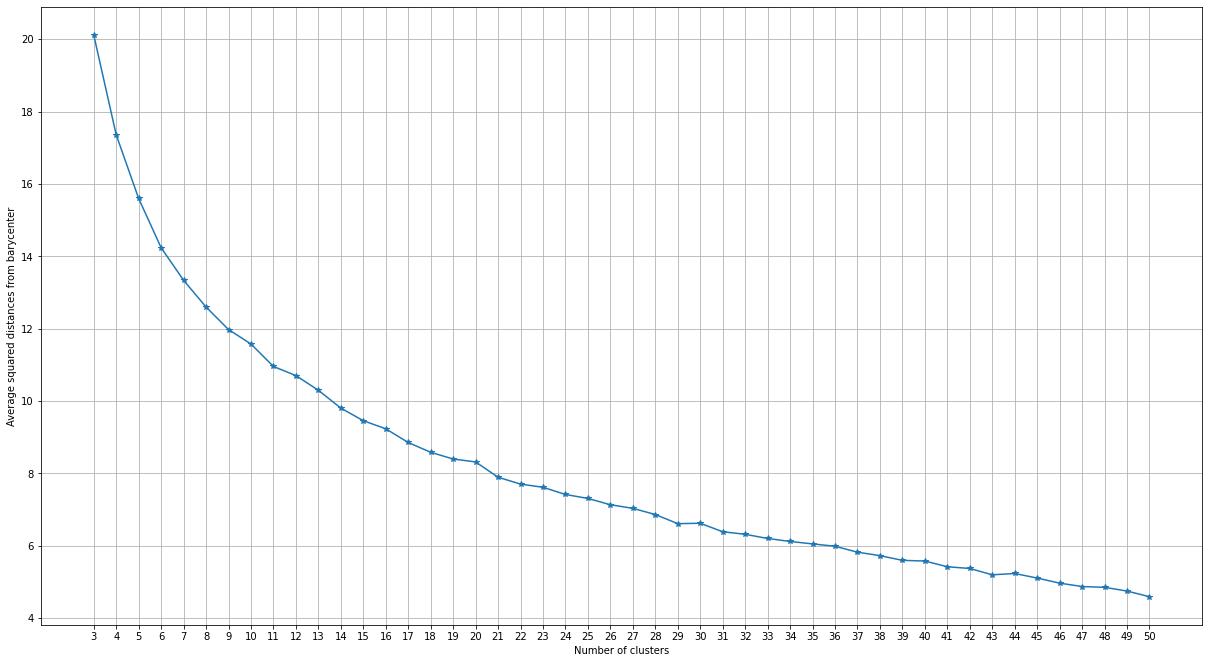

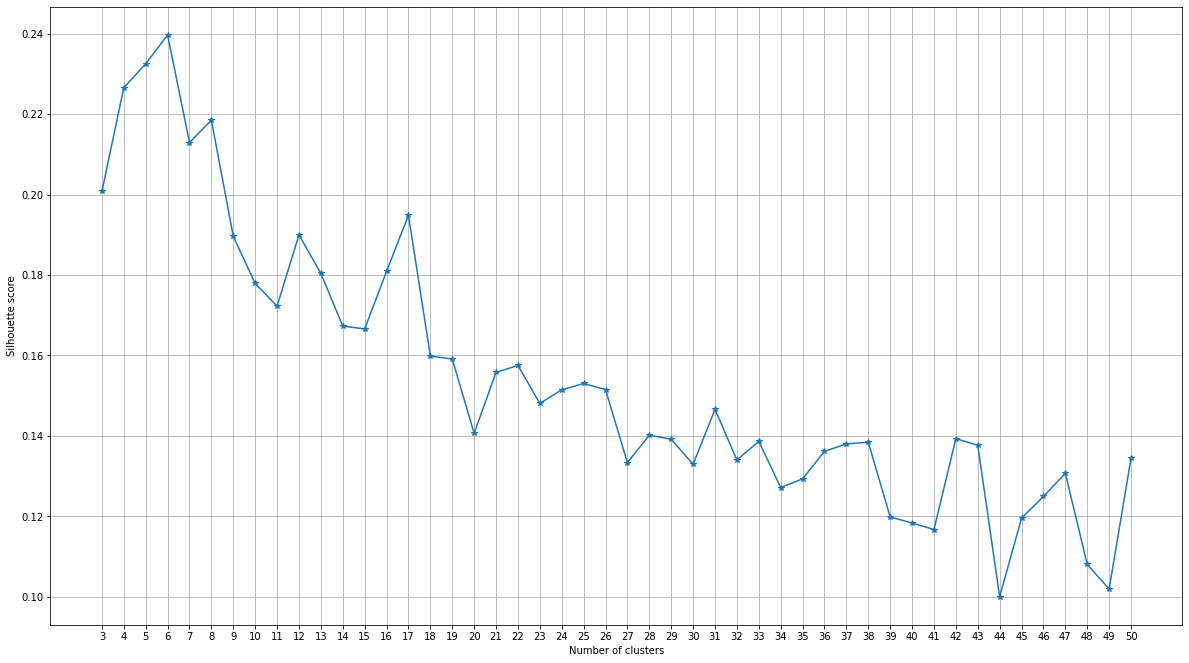

In [18]:
# K-Means clustering with different values of number of clusters

if clustering_algorithm == 'kMeans':
    clustering_results, silhouette, inertia = try_k_means_varying_k(df_all_lookup_scaled.T,
                                                                    use_ts_kmeans=True,
                                                                    max_num_clusters=max_num_clusters,
                                                                    n_init=10)
    
    # Elbow plot of inertia
    plot_kpi_by_num_clusters(inertia, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette, 'Silhouette score')

In [19]:
# Hierarchical clustering

if clustering_algorithm == 'hierarchical':

    start = time.time()
    
    hier_clust_fit, linkage = \
        hierarchical_clustering_and_dendrogram(df_all_lookup_scaled.T, linkage_hierarchical_clustering)

    # Find clustering results for different values of number of clusters from dendrogram
    clustering_results = {}
    for i in range(3, max_num_clusters+1):
        clusters = fcluster(linkage, t=i, criterion='maxclust')
        clustering_results[i] = clusters

    # Silhouette scores and inertia for the different numbers of clusters
    silhouette_scores = {}
    inertia_scores = {}
    for i in clustering_results:
        sil_score = silhouette_score(df_all_lookup_scaled.T,
                                     clustering_results[i], metric='euclidean')
        silhouette_scores[i] = sil_score
        inertia_scores[i] = compute_inertia(df_all_lookup_scaled.T, clustering_results[i])
        
    print('Elapsed time: ' + str(time.time() - start))

    # Plot of insertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

In [23]:
# Build df with cluster label per each curve

# Number of clusters for the result to be saved
num_clusters = 6

df_clustering_results = pd.DataFrame(columns=['curveId', 'cluster_label'])
df_clustering_results['curveId'] = df_all_lookup_scaled.T.index
df_clustering_results['cluster_label'] = clustering_results[num_clusters]

df_info = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    rename(columns={'CurveID': 'curveId'})

df_clustering_results = df_clustering_results.merge(df_info)\
    [['curveId', 'Perimeter', 'MS_Sector', 'MS_Group', 'cluster_label']]

df_clustering_results.to_csv('../Output/4.3_Clustering_Results/cluster_issuer_autoencoder.csv', sep=';')

Number of clusters for silhouette plot: 6
For n_clusters = 6 The average silhouette_score is : 0.23969973352576285


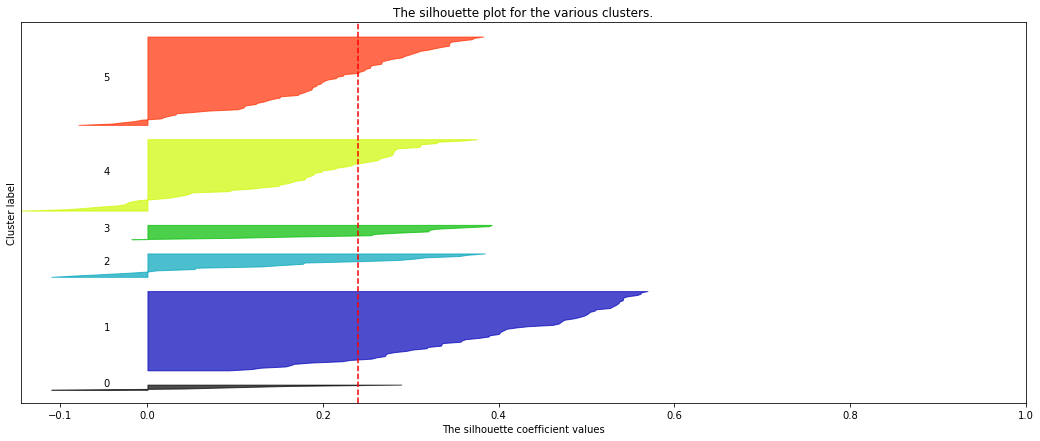

In [27]:
silhouette_plot(df_all_lookup_scaled.T, clustering_results[num_clusters])

## Produce output

In [15]:
# K MEANS
num_clusters = 23

# if use_differences:
km_fit = KMeans(n_clusters=num_clusters, max_iter=50, random_state=0,
                         n_init=10).\
    fit(df_all_lookup_scaled.T.fillna(0))
# else:
#     km_fit = TimeSeriesKMeans(n_clusters=num_clusters, metric=k_means_distance, max_iter=50, random_state=0,
#                          n_init=10).\
#     fit(df_all_lookup_scaled.T.fillna(0))
km_labels = km_fit.labels_
print('no of clusters ' + str(num_clusters))
print(silhouette_score(df_all_lookup_scaled.T.fillna(0), km_labels, metric=k_means_distance))

# Build df with result
df_result = df_all_lookup_scaled.T
df_result['cluster_label'] = km_labels
df_result = df_result['cluster_label']
df_result = pd.DataFrame(df_result).reset_index()
df_result = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_result)
df_result['MS_Sector'] = np.where(df_result['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_result['MS_Sector'])
df_result.to_csv('../Output/4.1-2_Clustering_Results/results_15.csv', sep=';', index=False)

no of clusters 23
0.03012914091565489


In [23]:
# HIERARCHICAL
num_clusters = 20

cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# Build df with result
df_result = df_all_lookup_scaled.T
df_result['cluster_label'] = cluster_labels
df_result = df_result['cluster_label']
df_result = pd.DataFrame(df_result).reset_index()
df_result = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    merge(df_result)
df_result['MS_Sector'] = np.where(df_result['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_result['MS_Sector'])
df_result.to_csv('../Output/4.1-2_Clustering_Results/results_17.csv', sep=';', index=False)